In [1]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np
import torch

from cart import MyEnv
#from q_online import Q_Online
from qpth.qp import QPFunction

%matplotlib inline

In [22]:
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.parameter import Parameter

from qpth.qp import QPFunction

class Q_Online(nn.Module):
    """Builds the strucre of the dnn based on QpNet for DQN
    The struture is FC-ReLU-FC-ReLU-Qp-[Q_value, u_opt[0]].
    """
    
    def __init__(self, num_input, num_output, num_hidden, num_u=5, eps=1e-4):
        """Inits the class.
        num_input: dimension of state variable
        num_output: dimension of action variable
        num_u: num_output * horizon length
        num_hidden: dimension in hidden FC layer
        num_equ >= (# eq constaints) * horizon length
        """
        super().__init__()
        self.num_input = num_input
        self.num_output = num_output
        self.num_hidden = num_hidden
        self.num_u = num_u
        self.eps = eps
        
        self.N = int(self.num_u/self.num_output)  # get the number of the finite steps in MPC
        self.num_ineq = 2*(num_u + num_input*(self.N-1))
        
        self.M = Parameter(torch.tril(torch.ones(num_input, num_input)),requires_grad=False)
        self.L = Parameter(torch.tril(torch.rand(num_input, num_input)))
        #self.L.retain_grad()
        self.M_P = Parameter(torch.tril(torch.ones(num_input, num_input)),requires_grad=False)
        self.L_P = Parameter(torch.tril(torch.rand(num_input, num_input)))
        #self.L_P.retain_grad()
        self.M_R = Parameter(torch.tril(torch.ones(num_output, num_output)),requires_grad=False)
        self.L_R = Parameter(torch.tril(torch.rand(num_output, num_output)))
        #self.L_R.retain_grad()
        self.I = Parameter(torch.eye(num_input),requires_grad=False)
        self.I_R = Parameter(torch.eye(num_output),requires_grad=False)
        self.A = Parameter(torch.Tensor(num_input,num_input).uniform_(-1,1))
        #self.A.retain_grad()
        self.B = Parameter(torch.Tensor(num_input,num_output).uniform_(-1,1))
        #self.B.retain_grad()
        self.u0 = Parameter(torch.zeros(num_u))
        #self.u0.retain_grad()
        self.s0 = Parameter(torch.ones(self.num_ineq))
        #self.s0.retain_grad()

        
        
        weight = torch.zeros(num_u)
        weight[0] = 1.0
        self.weight = Parameter(weight,requires_grad=False)

                
    def forward(self, x):
        """Builds the forward strucre of the QPNet.
        Sequence: FC-ReLU-(BN)-FC-ReLU-(BN)-QP-[Q_value, u_opt[0]].
        """
        
        A_hat = self.build_A_block()
        B_hat = self.build_B_block()
        
        # set up the QP parameters Q=L*L^T+ϵ*I, h = G*u_0+s_0
        L = self.M*self.L
        Q = L.mm(L.t()) + self.eps*self.I
        L_P = self.M_P*self.L_P
        P = L_P.mm(L_P.t()) + self.eps*self.I
        L_R = self.M_R*self.L_R
        R = L_R.mm(L_R.t()) + self.eps*self.I_R
        Q_hat, Q_diag = self.build_Q_block(Q, P, R, B_hat) 
        
        G = self.build_G_block(B_hat)
        h = G.mv(self.u0)+self.s0
        
        # linear layer  p = 2 * (Q_hat*B_hat)^T * (A_hat*x)
        nBatch = x.size(0)
        x = x.view(nBatch, -1)
        x = 2*(A_hat.mm(x.t())).t().mm(Q_diag.mm(B_hat))
        

        # gets the solution of the basic optimization problem
        e = Variable(torch.Tensor())
        u_opt = QPFunction(verbose=-1)(Q_hat, x, G, h, e, e)
        u0 = u_opt.mv(self.weight)
        Q_value = (u_opt.mm(Q_hat)*u_opt/2 + x*u_opt).sum(1).unsqueeze(1)
        
        return Q_value, u0

    def build_A_block(self):
        """
        [A]
        [A^2] 
        [A^3]
        [...]
        """
        N = self.N  # number of MPC steps
        A = self.A
        
        row_list = [A]  # reocrd the every row in B_hat
        
        for i in range(1, N-1):
            A = A.mm(A)
            row_list.append(A)
        return torch.cat(row_list,0)
    
    def build_B_block(self):
        """In MPC, express x vector in u vector and compute the new big B_hat matrix
        [B 0 0 ...
        [AB B 0
        ...
        """

        N = self.N  # number of MPC steps
        row_list = []  # reocrd the every row in B_hat
        
        first_block = self.B
        zero = Variable(torch.zeros(self.num_input, self.num_output*(N-1)))
        zero = self.vari_gpu(zero)
        row= torch.cat([first_block, zero],1)
        row_list.append(row)
        
        for i in range(1, N-1):
            first_block = self.A.mm(first_block)
            row = torch.cat([first_block, row[:,:self.num_output*(N-1)]],1)
            row_list.append(row)  
            
        return torch.cat(row_list,0)
        
        
    def build_Qdiagnol_block(self, Q, P):
        """ (num_imput*(N-1)) x (num_imput*(N-1))
        The last block is P for x(N)"""
        
        N = self.N-1  # number of MPC steps
        num_input = self.num_input
        
        row_list = []  # reocrd the every row in B_hat
        zero = Variable(torch.zeros(num_input, num_input*(N-1)))
        zero = self.vari_gpu(zero)
        row_long = torch.cat([zero, Q, zero],1)  # [0 0 ... Q 0 0 ...]
        for i in range(N, 1, -1):
            row_list.append(row_long[:, (i-1)*num_input : (i+N-1)*num_input])
            
        row = torch.cat([zero, P],1)  # last line by [0 P]
        row_list.append(row)
        
        return torch.cat(row_list,0)
    
    def build_Rdiagnol_block(self, R):
        """
        [R 0 0 ...
        [0 R 0
        ...
        """
        N = self.N  # number of MPC steps
        num_output = self.num_output
        
        row_list = []  # reocrd the every row in B_hat
        zero = Variable(torch.zeros(num_output, num_output*(N-1)))
        zero = self.vari_gpu(zero)
        row_long = torch.cat([zero, R, zero],1)  # [0 0 ... Q 0 0 ...]
        
        for i in range(N, 0, -1):
            row_list.append(row_long[:, (i-1)*num_output : (i+N-1)*num_output])
        return torch.cat(row_list,0)
        
    def build_Q_block(self, Q, P, R, B_hat):
        """Build the Q_hat matrix so that MPC is tranfered into basic optimization problem
        Q_hat = B_hat^T * diag(Q) * B_hat + diag(R)
        """
        
        Q_diag = self.build_Qdiagnol_block(Q,P)
        R_diag = self.build_Rdiagnol_block(R)
        Q_hat = B_hat.t().mm(Q_diag.mm(B_hat)) + R_diag
        return Q_hat,Q_diag 
        
        
    def build_G_block(self,B_hat):
        """Build the G matrix so that MPC is tranfered into basic optimization problem
        G = [eye(num_u)]
            [   B_hat  ]
            [-eye(num_u)]
            [  -B_hat  ]
        """
        
        eye = Variable(torch.eye(self.num_u))
        eye = self.vari_gpu(eye)
        G = torch.cat((eye, -eye, B_hat, -B_hat), 0)
        # print(self.B_hat)
        # print(G.size())
        return G
    
    def vari_gpu(self, var):
        if torch.cuda.is_available():
            var = var.cuda()
            
        return var

    def act(self, state, epsilon, env):
        """The action excuted by epsilon-greedy exploration
        """
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state)).unsqueeze(0) # adds extra dim when single input
            state = self.vari_gpu(state)
            _, u_opt = self.forward(state)
            action = (u_opt.cpu().detach().numpy())  # compute the u*[0] 
            #print('act:q_value ',q_value)
            #print('act:model action ',action)
        else:
            rand = np.random.rand(int(np.array(env.action_space.shape)))
            high = env.action_space.high
            low = env.action_space.low
            action = low + rand*(high-low)
            #print('act: ',action)
        return action


In [23]:
def train(state,action, next_state, reward, done, Variable):
    """Online training for the network.
    Returns the loss.
    """
    
    state      = Variable(torch.FloatTensor(state)).unsqueeze(0)
    next_state = Variable(torch.FloatTensor(next_state)).unsqueeze(0)
    action     = Variable(torch.FloatTensor(action)).unsqueeze(0)
    reward     = Variable(torch.FloatTensor([reward])).unsqueeze(0)
    done       = Variable(torch.FloatTensor([done])).unsqueeze(0)
    
    q_value, _ = model(state)
    next_q_value, _ = model(next_state)
    #print('loss:q_values',q_values.size())
    #print('loss:action', action.size())
    expected_q_value = reward + gamma * next_q_value * (1-done)
    loss = loss_fun(expected_q_value, q_value)
        
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    return loss.data

# Epsilon-greedy exploration
# The epsilon decreases exponetially as time goes by.
def greedy_epsilon(epoch):
    epsilon_start = 1.0
    epsilon_final = 0.01
    epsilon_decay = 500
    epsilon = epsilon_final + (epsilon_start-epsilon_final) * math.exp(-1.*epoch/epsilon_decay)
    return epsilon

#  Initiate the model

In [24]:
model = Q_Online(num_input=2, num_output=1,num_hidden=20, num_u=5) 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
loss_fun = torch.nn.MSELoss()  # Initializes the loss function
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Initializes the optimizer

env = MyEnv()
gamma = 0.99

state = env.reset()
losses = []
trac_time = []
trac_reward = []

if torch.cuda.is_available():  # cuda or cpu
    Variable = lambda *args, **kwargs: \
        torch.autograd.Variable(*args, **kwargs).cuda()  # Variable: not require gra
else:
    Variable = lambda *args, **kwargs: \
        torch.autograd.Variable(*args, **kwargs)

# Train the model

In [25]:
# from instructor import Instructor
# instructor = Instructor(model, optimizer, loss_fun)

t = 0  # records the number of periods in one trajectory
r = 0  # records the reward in one trajectory
# train the data

for epoch in range(10000):
    env.render()  # visualization of the cart position 
    epsilon = greedy_epsilon(epoch)
    action = model.act(state, epsilon,env)
    next_state, reward, done, _ = env.step(action)
    losses.append(train(state,action, next_state, reward, done, Variable))
    state = next_state
    t += 1
    r += reward

    if done:
        state = env.reset()
        trac_time.append(t)
        trac_reward.append(r)
        t = 0
        r = 0

    if (epoch+1)%100 == 0:
        print('[epoch: %d] training loss: %.3f' %
                          (epoch + 1, losses[epoch]))
    
env.close()

[epoch: 100] training loss: 1620600.125
[epoch: 200] training loss: 3070622.750
[epoch: 300] training loss: 1546173.500
[epoch: 400] training loss: 26.038
[epoch: 500] training loss: 1023.806
[epoch: 600] training loss: 0.019
[epoch: 700] training loss: 718.471
[epoch: 800] training loss: 836.002
[epoch: 900] training loss: 339.220
[epoch: 1000] training loss: 5048467.000
[epoch: 1100] training loss: 69.502
[epoch: 1200] training loss: 2852.202
[epoch: 1300] training loss: 0.159
[epoch: 1400] training loss: 18.514
[epoch: 1500] training loss: 1585.352
[epoch: 1600] training loss: 1610.893
[epoch: 1700] training loss: 236.279
[epoch: 1800] training loss: 362.979
[epoch: 1900] training loss: 0.011
[epoch: 2000] training loss: 103.153
[epoch: 2100] training loss: 11.265
[epoch: 2200] training loss: 0.025
[epoch: 2300] training loss: 53.784
[epoch: 2400] training loss: 4.842
[epoch: 2500] training loss: 2000.182
[epoch: 2600] training loss: 2345.818
[epoch: 2700] training loss: 312.522
[ep

In [14]:
env.close()

Text(0.5, 0, 'tractory sequence')

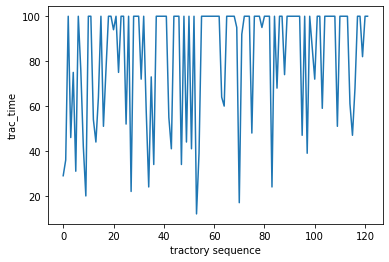

In [26]:
plt.plot(trac_time)
plt.ylabel('trac_time')
plt.xlabel('tractory sequence')

Text(0.5, 0, 'tractory sequence')

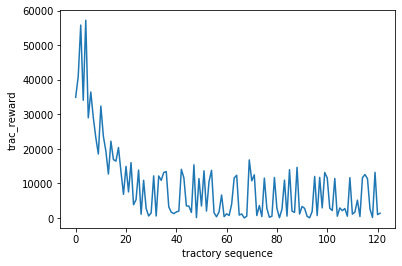

In [27]:
plt.plot(trac_reward)
plt.ylabel('trac_reward')
plt.xlabel('tractory sequence')

Text(0.5, 0, 'losses')

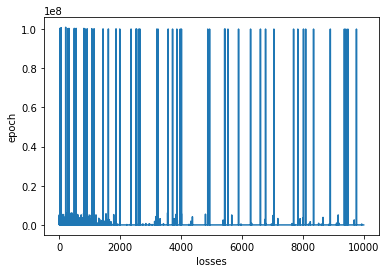

In [28]:
plt.plot(losses)
plt.ylabel('epoch')
plt.xlabel('losses')